<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/Multi-Sensor-Fusion-Crash-Detection/TransitLK_MSFCD_CVP_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Multi Sensor Fusion Crash Detection - Computer Vision Model**

##**Setup and Load Data**

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")

#mount drive
from google.colab import drive
drive.mount('/content/drive')

#dataset path
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v2-2.folder'

print(f"\nDataset path: {BASE_PATH}")

TensorFlow Version: 2.19.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Dataset path: /content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v2-2.folder


##**Exploratory Data Analysis**

Exploratory Data Analysis

Dataset structure found:
  train: Crash=429, Normal=219, Total=648
  test: Crash=61, Normal=32, Total=93
  valid: Crash=124, Normal=62, Total=186

Dataset loaded: 927 images
   split  label                                           filename
0  train  crash  frame_0316_jpg.rf.2e3460adf60db2c8091777e18da8...
1  train  crash  frame_0202_jpg.rf.2ffc0ff954d81acb788eabe6ad17...
2  train  crash  frame_0231_jpg.rf.c85b4f367ab08989730f78976fcf...
3  train  crash  frame_0275_jpg.rf.c3cb0af079e747d8df205cc34615...
4  train  crash  frame_0162_jpg.rf.2347565e2612c089987ae0d74ba3...

1. Class Distribution (Crash vs Normal):
label
crash     614
normal    313
Name: count, dtype: int64

Crash rate: 66.24%


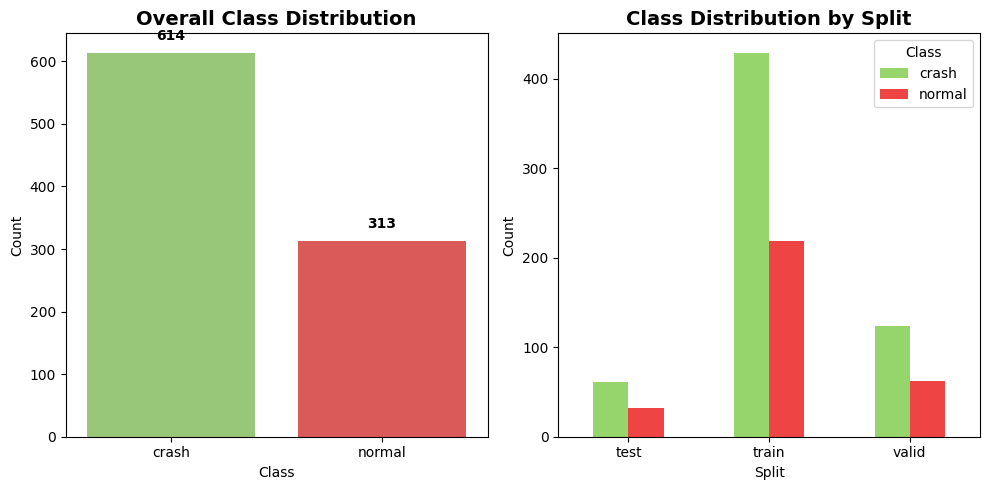


2. Sample Images:


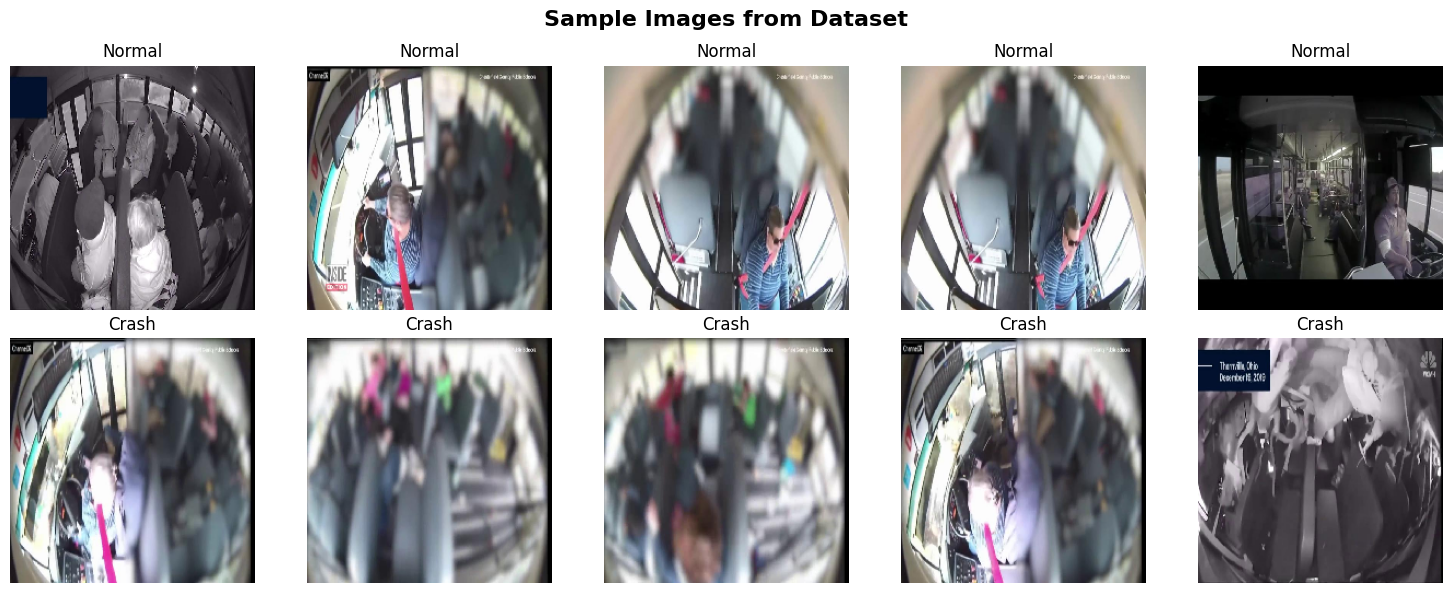

In [3]:
print("Exploratory Data Analysis\n")

#check if path exists and list structure
import os
if os.path.exists(BASE_PATH):
    print("Dataset structure found:")
    for split in ['train', 'test', 'valid']:
        split_path = os.path.join(BASE_PATH, split)
        if os.path.exists(split_path):
            crash_dir = os.path.join(split_path, 'crash')
            normal_dir = os.path.join(split_path, 'normal')
            crash_count = len([f for f in os.listdir(crash_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(crash_dir) else 0
            normal_count = len([f for f in os.listdir(normal_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(normal_dir) else 0
            print(f"  {split}: Crash={crash_count}, Normal={normal_count}, Total={crash_count + normal_count}")
else:
    print("Path not found! Please check your dataset location.")

#create dataframe for analysis
data = []
for split in ['train', 'test', 'valid']:
    for label in ['crash', 'normal']:
        folder = os.path.join(BASE_PATH, split, label)
        if os.path.exists(folder):
            files = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            for f in files:
                data.append({'split': split, 'label': label, 'filename': f})

df = pd.DataFrame(data)
print(f"\nDataset loaded: {len(df)} images")
print(df.head())

#class distribution analysis
print("\n1. Class Distribution (Crash vs Normal):")
class_counts = df['label'].value_counts()
print(class_counts)
print(f"\nCrash rate: {class_counts.get('crash', 0)/len(df):.2%}")

#visualize class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#96d46c','#ef4444'])
plt.title('Overall Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 20, str(v), ha='center', fontweight='bold')

#distribution by split
plt.subplot(1, 2, 2)
split_counts = df.groupby(['split', 'label']).size().unstack(fill_value=0)
split_counts.plot(kind='bar', ax=plt.gca(), color=['#96d46c', '#ef4444'])
plt.title('Class Distribution by Split', fontsize=14, fontweight='bold')
plt.xlabel('Split')
plt.ylabel('Count')
plt.legend(title='Class')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

#show sample images
print("\n2. Sample Images:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

for idx, label in enumerate(['normal', 'crash']):
    label_df = df[df['label'] == label]
    if len(label_df) > 0:
        sample_files = label_df.sample(min(5, len(label_df)))['filename'].values
        for i, filename in enumerate(sample_files):
            #get full path (assuming from train split for samples)
            img_path = os.path.join(BASE_PATH, 'train', label, filename)
            if not os.path.exists(img_path):
                #try other splits if not in train
                for split in ['valid', 'test']:
                    img_path = os.path.join(BASE_PATH, split, label, filename)
                    if os.path.exists(img_path):
                        break

            if os.path.exists(img_path):
                img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
                axes[idx, i].imshow(img)
                axes[idx, i].set_title(f'{label.capitalize()}')
                axes[idx, i].axis('off')

plt.tight_layout()
plt.show()

##**Data Preprocessing and Configuration**

In [4]:
print("Data Preprocessing & Configuration")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

#parameters
params = {
    'target_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'class_mode': 'binary',
    'seed': 42
}

print(f"\nImage Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")

#check class distribution in training set specifically
train_crash = len(os.listdir(os.path.join(BASE_PATH, 'train', 'crash')))
train_normal = len(os.listdir(os.path.join(BASE_PATH, 'train', 'normal')))
print(f"\nTraining set - Crash: {train_crash}, Normal: {train_normal}")

if train_crash > 0 and train_normal > 0:
    imbalance_ratio = train_normal / train_crash
    print(f"Imbalance Ratio (Normal:Crash): {imbalance_ratio:.2f}:1")

    if imbalance_ratio > 1.5:
        print("Dataset is imbalanced. Will use class weights.")
        use_class_weights = True
    else:
        use_class_weights = False
else:
    use_class_weights = False

Data Preprocessing & Configuration

Image Size: (224, 224)
Batch Size: 32

Training set - Crash: 429, Normal: 219
Imbalance Ratio (Normal:Crash): 0.51:1


##**Handle CLass Imbalance**

In [5]:
print("Handling Class Imbalance")

if use_class_weights:
    #calculate class weights (inverse the frequency)
    total = train_crash + train_normal
    weight_for_crash = (1 / train_crash) * (total / 2.0)
    weight_for_normal = (1 / train_normal) * (total / 2.0)

    class_weights = {0: weight_for_normal, 1: weight_for_crash}
    print(f"Class Weights: {class_weights}")
else:
    class_weights = None
    print("No class weights needed (balanced dataset)")

Handling Class Imbalance
No class weights needed (balanced dataset)


##**Data Generation**

In [6]:
print("Creating Data Generators")

#training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

#validation/test data - only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

#create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'train'),
    **params,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'valid'),
    **params,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'test'),
    **params,
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

#verify class indices
print(f"\nClass indices: {train_generator.class_indices}")

Creating Data Generators
Found 650 images belonging to 4 classes.
Found 186 images belonging to 2 classes.
Found 93 images belonging to 2 classes.

Training samples: 650
Validation samples: 186
Test samples: 93

Class indices: {'Unlabeledc': 0, 'crash': 1, 'crashc': 2, 'normal': 3}


##**Building Model Using Transfer Learning**

In [7]:
print("Building Model")

def build_model():
    #MobileNetV2 is lightweight and good for edge deployment as we are using phone as a central
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        alpha=1.0
    )

    #freeze base model initially (similar to training on features first)
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)  #binary classification

    model = Model(inputs, outputs)
    return model, base_model

model, base_model = build_model()

#compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

#model architecture
print("\nModel Architecture:")
model.summary()

Building Model
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,713 (9.26 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

#**Model Training - Phase 1**

In [8]:
print("Model Training - Phase 1")

callbacks_phase1 = [
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'crash_model_phase1.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=100,
    callbacks=callbacks_phase1,
    class_weight=class_weights,
    verbose=1
)

print("Model Training Complete!")

Model Training - Phase 1
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3334 - auc: 0.7795 - loss: 0.6301
Epoch 1: val_auc improved from -inf to 0.93761, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 118s 6s/step - accuracy: 0.3317 - auc: 0.7844 - loss: 0.6245 - val_accuracy: 0.7750 - val_auc: 0.9376 - val_loss: 0.4131 - learning_rate: 1.0000e-04
Epoch 2/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2500 - auc: 0.0000e+00 - loss: -0.1078
Epoch 2: val_auc improved from 0.93761 to 0.94724, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 770ms/step - accuracy: 0.2500 - auc: 0.0000e+00 - loss: -0.1078 - val_accuracy: 0.7812 - val_auc: 0.9472 - val_loss: 0.4051 - learning_rate: 1.0000e-04
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2768 - auc: 0.6864 - loss: 0.1917
Epoch 3: val_auc improved from 0.94724 to 0.99261, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2751 - auc: 0.6966 - loss: 0.1820 - val_accuracy: 0.9625 - val_auc: 0.9926 - val_loss: 0.2920 - learning_rate: 1.0000e-04
Epoch 4/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2500 - auc: 0.0000e+00 - loss: 0.0050
Epoch 4: val_auc improved from 0.99261 to 0.99306, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step - accuracy: 0.2500 - auc: 0.0000e+00 - loss: 0.0050 - val_accuracy: 0.9625 - val_auc: 0.9931 - val_loss: 0.2875 - learning_rate: 1.0000e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1926 - auc: 0.0000e+00 - loss: -0.2969
Epoch 5: val_auc improved from 0.99306 to 0.99664, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.1927 - auc: 0.0000e+00 - loss: -0.2976 - val_accuracy: 0.9688 - val_auc: 0.9966 - val_loss: 0.2424 - learning_rate: 1.0000e-04
Epoch 6/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 18s 967ms/step - accuracy: 0.2812 - auc: 0.3548 - loss: 0.1163
Epoch 6: val_auc improved from 0.99664 to 0.99686, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 387ms/step - accuracy: 0.2812 - auc: 0.3548 - loss: 0.1163 - val_accuracy: 0.9625 - val_auc: 0.9969 - val_loss: 0.2421 - learning_rate: 1.0000e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1779 - auc: 0.4999 - loss: -0.5235
Epoch 7: val_auc improved from 0.99686 to 0.99877, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.1787 - auc: 0.5094 - loss: -0.5196 - val_accuracy: 0.9000 - val_auc: 0.9988 - val_loss: 0.2407 - learning_rate: 1.0000e-04
Epoch 8/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2500 - auc: 0.0000e+00 - loss: -0.7663
Epoch 8: val_auc did not improve from 0.99877
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 700ms/step - accuracy: 0.2500 - auc: 0.0000e+00 - loss: -0.7663 - val_accuracy: 0.9000 - val_auc: 0.9988 - val_loss: 0.2413 - learning_rate: 1.0000e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2080 - auc: 0.4812 - loss: -0.4315
Epoch 9: val_auc improved from 0.99877 to 0.99933, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2070 - auc: 0.4885 - loss: -0.4451 - val_accuracy: 0.8687 - val_auc: 0.9993 - val_loss: 0.2624 - learning_rate: 1.0000e-04
Epoch 10/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 18s 974ms/step - accuracy: 0.1562 - auc: 0.0000e+00 - loss: -1.5837
Epoch 10: val_auc did not improve from 0.99933
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.1562 - auc: 0.0000e+00 - loss: -1.5837 - val_accuracy: 0.8687 - val_auc: 0.9993 - val_loss: 0.2635 - learning_rate: 1.0000e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2004 - auc: 0.2329 - loss: -1.1221
Epoch 11: val_auc did not improve from 0.99933
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1998 - auc: 0.2435 - loss: -1.1125 - val_accuracy: 0.8438 - val_auc: 0.9993 - val_loss: 0.3020 - learning_rate: 1.0000e-04
Epoch 12/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2188 - auc: 0.0000e+00 - loss: -0.9641
Epoch 12: val_auc did not improve from 0.99933

Epoch 12: R

20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.1627 - auc: 0.4187 - loss: -1.4243 - val_accuracy: 0.8062 - val_auc: 0.9993 - val_loss: 0.3686 - learning_rate: 5.0000e-05
Epoch 16/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 18s 1000ms/step - accuracy: 0.2812 - auc: 0.0000e+00 - loss: -0.8466
Epoch 16: val_auc did not improve from 0.99933
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - accuracy: 0.2812 - auc: 0.0000e+00 - loss: -0.8466 - val_accuracy: 0.8062 - val_auc: 0.9993 - val_loss: 0.3714 - learning_rate: 5.0000e-05
Epoch 17/100
 5/20 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.1593 - auc: 0.5001 - loss: -1.6873

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v2-2.folder/train/crash/324_png.rf.67d1a28bae58af6c644adcfab741b017.jpg'
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/image_utils.py", line 235, in load_img
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v2-2.folder/train/crash/324_png.rf.67d1a28bae58af6c644adcfab741b017.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_9948]

#**Model Training - Phase 2 (Fine Tuning)**

In [ ]:
print("Fine Tuning Model")

#unfreeze top 30 layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

#recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), #10x lower for fine tuning
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print(f"Trainable variables: {len(model.trainable_variables)}")

callbacks_phase2 = [
    EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'crash_model_final.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    initial_epoch=len(history1.history['loss']),
    callbacks=callbacks_phase2,
    class_weight=class_weights,
    verbose=1
)

print("Training Complete!")

##**Model Evaluation**

In [ ]:
print("Model Evaluation")

#load best model
model = tf.keras.models.load_model('crash_model_final.h5')

#get predictions on test set
test_generator.reset()
y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

#get true labels
y_true = test_generator.classes[:len(y_pred)]  # Match lengths

print(f"\nTest samples evaluated: {len(y_true)}")

#calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.2%}")

#classification report
print("\nClassification Report:")
target_names = ['Crash', 'Normal'] if test_generator.class_indices['crash'] == 0 else ['Normal', 'Crash']
print(classification_report(y_true, y_pred, target_names=target_names))

#confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

#visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:len(y_true)])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.show()

#**Training History**

In [ ]:
def plot_training(history1, history2):
    #combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    auc = history1.history['auc'] + history2.history['auc']
    val_auc = history1.history['val_auc'] + history2.history['val_auc']

    epochs = range(1, len(acc) + 1)
    phase1_epochs = len(history1.history['accuracy'])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    #accuracy
    axes[0].plot(epochs, acc, 'b-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    axes[0].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[0].set_title('Model Accuracy', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    #loss
    axes[1].plot(epochs, loss, 'b-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'r-', label='Validation Loss')
    axes[1].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[1].set_title('Model Loss', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # AUC
    axes[2].plot(epochs, auc, 'b-', label='Training AUC')
    axes[2].plot(epochs, val_auc, 'r-', label='Validation AUC')
    axes[2].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[2].set_title('Model AUC', fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training(history1, history2)

##**Interface Functions for Future Use**

In [ ]:
def predict_crash(image_path, model, threshold=0.5):
    """
    Predict crash probability for a single image
    Returns: dict with probability and class
    """
    img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = tf.expand_dims(img_array, 0)

    prob = model.predict(img_array, verbose=0)[0][0]

    #determine class based on class_indices
    #if crash is class 0, then prob < 0.5 is crash, else normal
    #if crash is class 1, then prob > 0.5 is crash
    is_crash = prob > threshold if test_generator.class_indices['crash'] == 1 else prob < threshold

    return {
        'crash_probability': float(prob),
        'is_crash': bool(is_crash),
        'predicted_class': 'crash' if is_crash else 'normal'
    }

# Test on a sample image
test_img_path = os.path.join(BASE_PATH, 'test', 'crash', os.listdir(os.path.join(BASE_PATH, 'test', 'crash'))[0])
result = predict_crash(test_img_path, model)
print(f"\nSample Prediction:")
print(f"Image: {test_img_path}")
print(f"Result: {result}")

##**Export Model as a Keras and Converting to TensorFlow Lite Model for Mobile Usage**

In [ ]:
from google.colab import files

print("Exporting Model")

#save Keras model
model.save('TransitLK_MSFCD_CVP_TF.h5')
print("Saved as TransitLK_MSFCD_CVP_TF.h5")

#convert to TnsorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('TransitLK_MSFCD_CVP_TF.tflite', 'wb') as f:
    f.write(tflite_model)
print("Saved as TransitLK_MSFCD_CVP_TF.tflite")

#download files
files.download('TransitLK_MSFCD_CVP_TF.h5')
files.download('TransitLK_MSFCD_CVP_TF.tflite')